# **Language model for generating text using various deep learning techniques**
This code generates text using language models that are implemented using various deep learning techniques. It uses the TensorFlow Keras library for creating and training deep learning models.

## **Step 1:** Install required libraries

---


The first step is to install the necessary libraries required to run the code. This code uses the `wikipedia` library to extract text data from Wikipedia, `re` library for performing regular expressions, `numpy` and `tensorflow` libraries for performing deep learning operations.

In [ ]:
# Install required packages
%pip install wikipedia

# Import necessary packages
import wikipedia
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Step 2:** Extract and preprocess data

---


The second step is to extract text data from Wikipedia and preprocess it for training the language models. The `data` variable is used to store the extracted text data, and the `maxlen` variable is used to set the maximum length of the sequence.

The `re` library is used to remove citations and special characters from the extracted text data. The text data is then converted to lowercase.

In [ ]:
# Define the maximum length of the sequence
maxlen = 20

# Extract the data from wikipedia
data = wikipedia.page("Trimmer (electronics)").content 
#***

# Preprocess the data
data = re.sub(r'\[[0-9]*\]', '', data)  # Remove citations
data = re.sub(r'[^a-zA-Z0-9\s]', '', data)  # Remove special characters
data = data[3000:].lower()  # Convert to lowercase

## **Step 3:** Tokenize the data

---

The third step is to tokenize the preprocessed data using the `Tokenizer` class from the TensorFlow Keras library. The `fit_on_texts` method is used to fit the tokenizer on the preprocessed data, and the` word_index` and `total_words `variables are used to store the word index and the total number of words in the text data.

In [ ]:
# Tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
word_index = tokenizer.word_index
total_words = len(word_index) + 1

# Create input sequences using the tokenizer
input_sequences = []
for line in data.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

## **Step 4:** Create input sequences

---


The fourth step is to create input sequences for training the language models. The `input_sequences` list is used to store the input sequences, and the `pad_sequences` method is used to pad the sequences to ensure they are all of the same length. The `predictors` and `label` variables are used to store the predictors and target for training the models.

In [ ]:
# Pad the sequences to ensure they are all the same length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


# Create predictors and target
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

# Convert target to categorical
label = keras.utils.to_categorical(label, num_classes=total_words)
print(len(label), len(predictors))

448 448


## **Step 5:** Define and train the models

---
The fifth step is to define and train the language models. Three different models are defined using the TensorFlow Keras library, and each model is trained using the `fit` method.

The `history` variables are used to store the training history of each model. The `learning_rate` and `optimizer` variables are used to set the learning rate and optimizer for compiling the models.

# **Model 1 - "LSTM-Bidirectional"**
This model uses an embedding layer to transform the input sequences to 100-dimensional vectors. It has a** Bidirectional LSTM layer** with 150 units that returns the sequences, followed by a 20% dropout layer. It then has another LSTM layer with 100 units that returns a single output. Finally, it has two fully connected layers, one with half the number of total words with ReLU activation and L2 regularization, and another with the number of total words and a softmax activation function.

In [1]:
learning_rate = 0.01
# < 

#Fitting process, SVD, adam ~ semnatic, 
optimizer = keras.optimizers.Adam(lr=learning_rate)

#
# Model 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])
model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Train the models
bs = 128
history1 = model1.fit(predictors, label, epochs=100, verbose=1, batch_size = bs)

NameError: name 'keras' is not defined

# **Model 2: "LSTM-Bidirectional-2"**
This model is similar to Model 1 but with two bidirectional LSTM layers to better capture the long-term dependencies in the input sequence.

In [ ]:
# Model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history2 = model2.fit(predictors, label, epochs=100, verbose=1, batch_size = bs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 93, 100)           24000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 93, 256)          234496    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 93, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 120)               30840     
                                                                 
 dense_7 (Dense)             (None, 240)              

# **Model 3: "Conv-LSTM"**
This model uses a convolutional layer followed by two LSTM layers to process the input sequence and predict the next word. The convolutional layer helps capture local patterns in the input sequence.

In [ ]:
# Model 3
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history3 = model3.fit(predictors, label, epochs=100, verbose=1, batch_size = bs)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 93, 100)           24000     
                                                                 
 conv1d (Conv1D)             (None, 93, 64)            19264     
                                                                 
 dropout_4 (Dropout)         (None, 93, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 93, 16)            5184      
                                                                 
 dropout_5 (Dropout)         (None, 93, 16)            0         
                                                                 
 lstm_9 (LSTM)               (None, 8)                 800       
                                                                 
 dense_8 (Dense)             (None, 120)              

## **Step 6:** Evaluate the models

---


The sixth step is to evaluate the performance of each model using the evaluate method. The visualization data is plotted for the `model1`, `model2`, and `model3` variables are used to store the models.

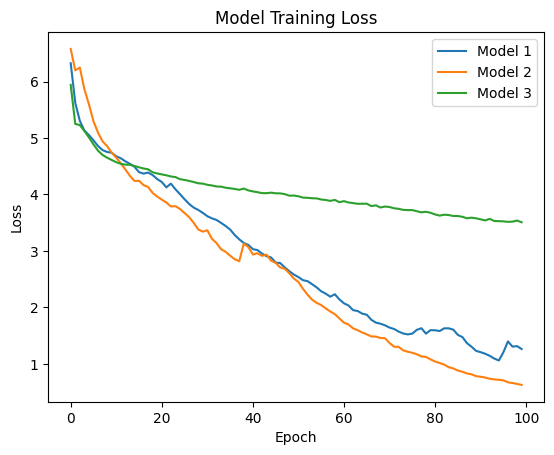

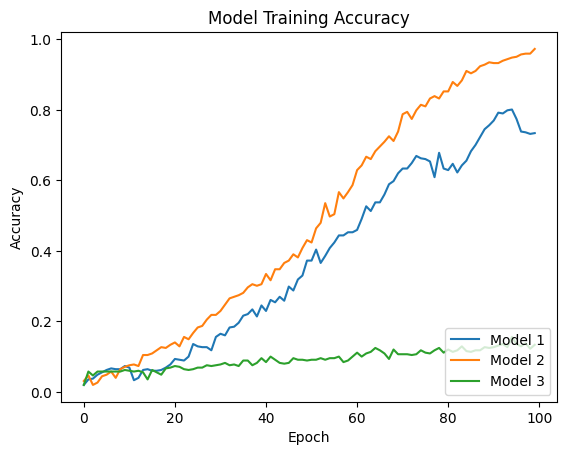

In [ ]:
# Plot the training loss and accuracy for each model
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Model 1', 'Model 2', 'Model 3'], loc='upper right')
plt.show()

plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Model 1', 'Model 2', 'Model 3'], loc='lower right')
plt.show()

## **Step 7:** Generate text using the trained models

---


The seventh step is to generate text using the trained models. The `generate_text` function is defined to generate text using the trained models. This function takes in a seed text, the number of words to generate, the model to use, and the maximum sequence length as input.

The `token_list` variable is used to store the tokenized version of the seed text, and the `pad_sequences` method is used to pad the sequences to ensure they are all of the same length. The `model.predict` method is used to predict the probability distribution of the next word, and the `np.argmax` method is used to get the index of the predicted word.

The predicted word is then added to the output text, and the function returns the generated text.

In [43]:
import numpy as np

def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted_probs, axis=-1)

        # Get the predicted word
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    
    output_text = seed_text.title()
    print("Generated Text:", output_text)

inp = "Two types of preset resistor are commonly found in circuits. The skeleton"

# Generate text using Model 1
print("Using Model 1:")
generate_text(inp, 5, model1, max_sequence_len)

# Generate text using Model 2
print("\nUsing Model 2:")
generate_text(inp, 5, model2, max_sequence_len)

# Generate text using Model 3
print("\nUsing Model 3:")
generate_text(inp, 7, model3, max_sequence_len)

Using Model 1:
Generated Text: Two Types Of Preset Resistor Are Commonly Found In Circuits. The Skeleton Top Known In Inductor To

Using Model 2:
Generated Text: Two Types Of Preset Resistor Are Commonly Found In Circuits. The Skeleton Top Of The Inductance And

Using Model 3:
Generated Text: Two Types Of Preset Resistor Are Commonly Found In Circuits. The Skeleton To Inductor To Inductor In Inductor The
